In [1]:
import numpy as np
import torch
from scipy.integrate import odeint
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from torch import nn, autograd
from src.nn import RNN
from src.duffing_generator import DuffingGeneratorClass
from src.physics_loss import physics_loss_class
import torch.optim as op 
%load_ext jupyter_ai

In [2]:
import os
# Plot the Duffing oscillator data
#plot_duffing_oscillator(d, a, b, gamma, w, x, y)
#plt.show()

In [3]:
import os
import resource
import sys
def print_memory_usage():
    rusage_denom = 1024.
    if sys.platform == 'darwin':
        rusage_denom = rusage_denom * rusage_denom
    mem = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / rusage_denom
    print(f"Memory usage: {mem} MB")

#print_memory_usage()

Input size of the linear layer: 8
Loss at Step 10 : 0.3941107392311096


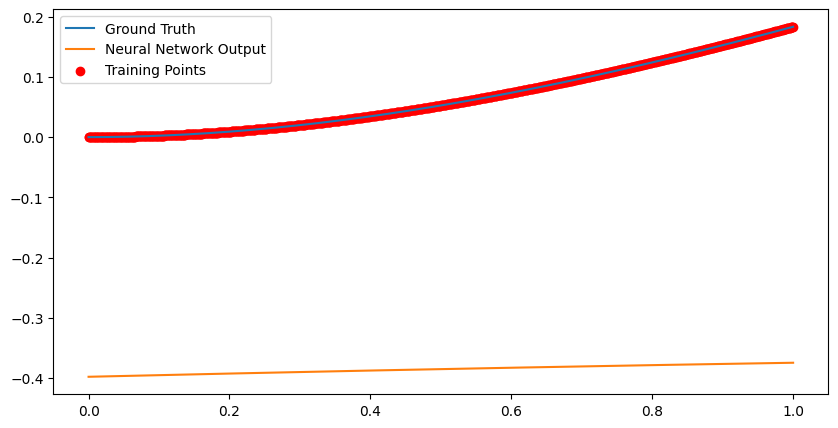

Loss at Step 10 : 0.3564600646495819


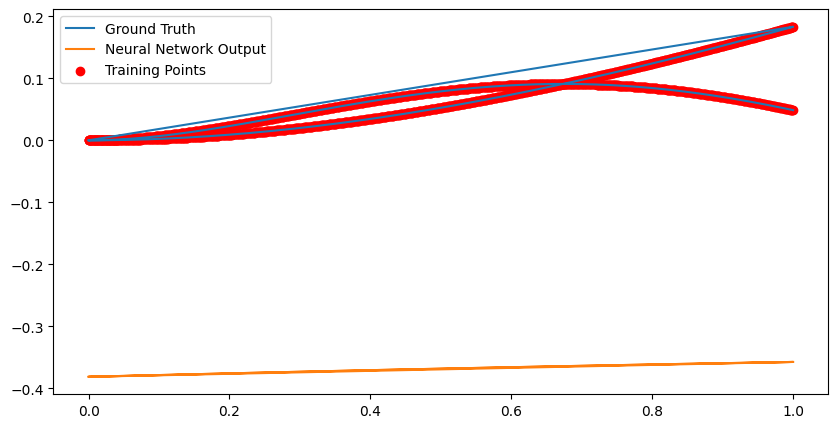

Loss at Step 10 : 0.29033681750297546


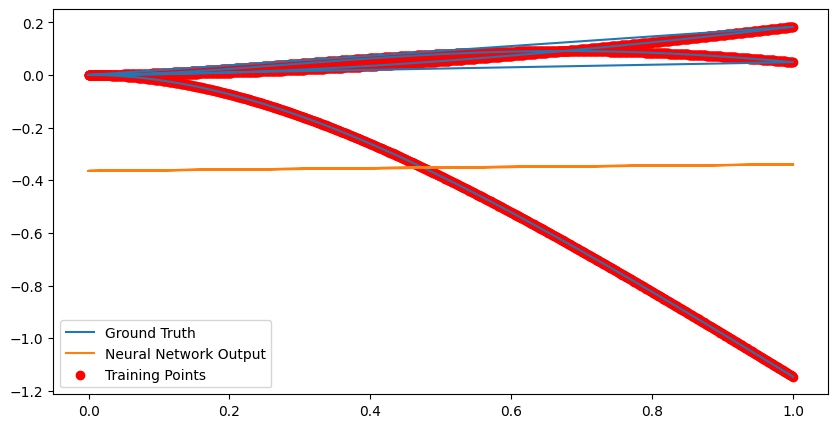

Loss at Step 10 : 0.2577628493309021


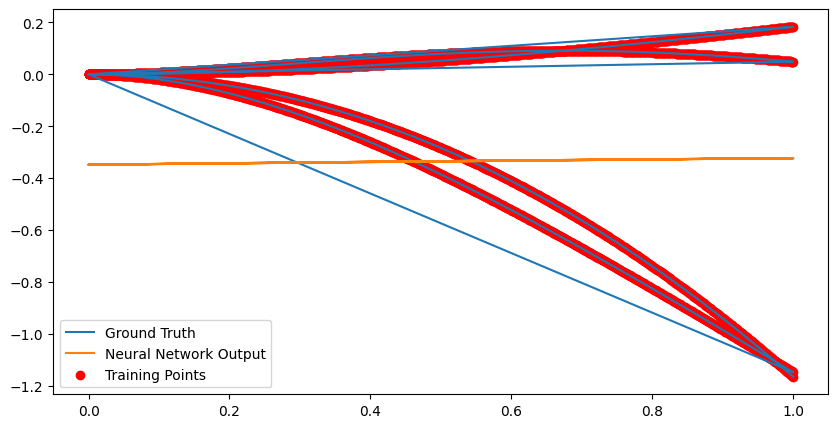

Loss at Step 10 : 0.16249515116214752


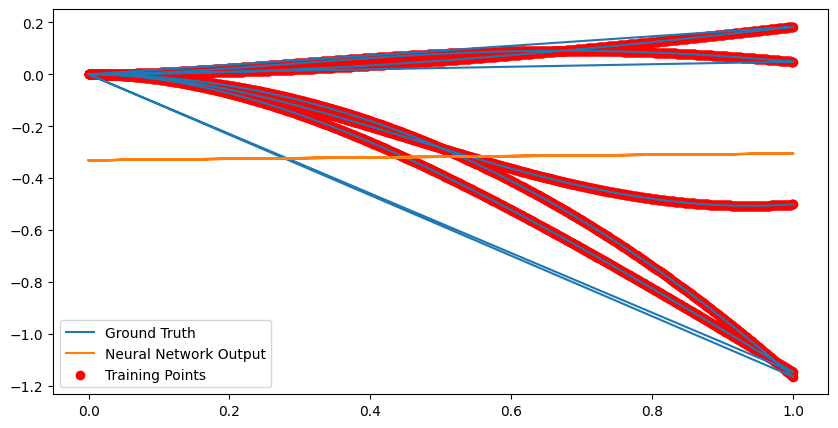

Loss at Step 10 : 0.3228861689567566


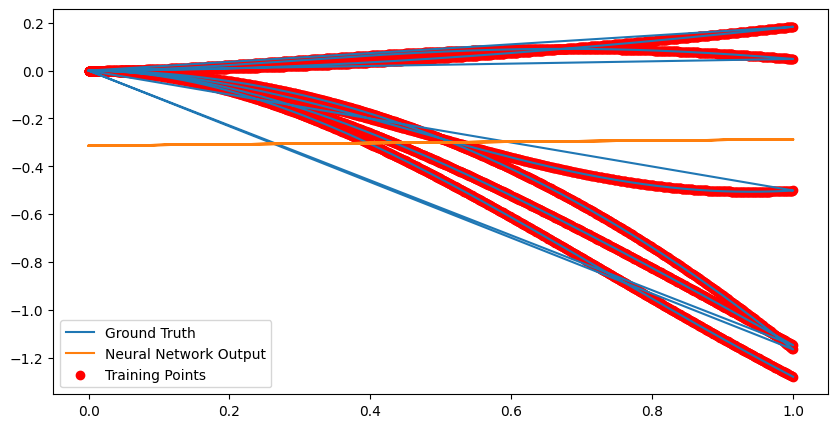

Loss at Step 10 : 0.31270021200180054


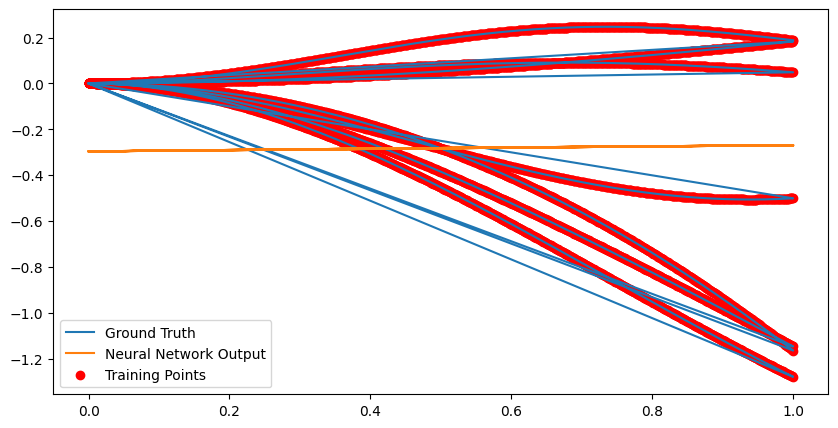

Loss at Step 10 : 0.1564774215221405


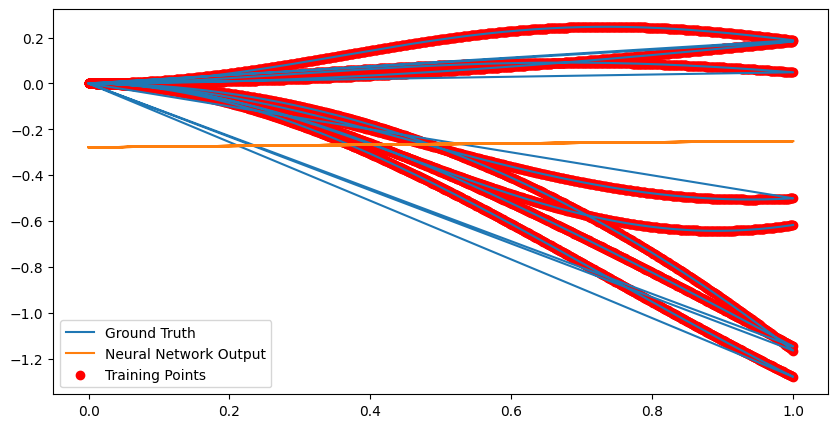

NameError: name 'n_steps' is not defined

In [4]:
# Initialization
x = torch.linspace(0, 1, 1000).view(-1, 1)
dg = DuffingGeneratorClass()  # Instantiate your class
model = RNN(1, 1, 8, 4)  # Use the RNN class instead of FCN
model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
torch.manual_seed(123)
physics_loss_instance = physics_loss_class()
# Set up the physics loss training locations
x_physics = torch.linspace(0, 1, 15).view(-1, 1).requires_grad_(True)
X_BOUNDARY = 0.0  # Example value, adjust as needed
F_BOUNDARY = 0.0  # Example value, adjust as needed
all_x_data = None
all_y_data = None
#print('initializing')
#print_memory_usage()

# Training loop
for i in range(100):
    optimizer.zero_grad()

    if (i + 1) % 10 == 0:
        batches = dg.duffing_generator()  # Generate new batches
        for batch_idx, batch in enumerate(batches):
            y, d, a, b, gamma, w, x = batch  # Unpack each batch
            #print("batch unpacking")
            #print_memory_usage()
            # Log the contents of the first few batches
           # if batch_idx < 3:  # Adjust this number to log more or fewer batches
            #    print(f"Batch {batch_idx}:")
             #   print("x:", x[:5])  # Log first 5 x values
              #  print("y:", y[:5])  # Log first 5 y values
               # print("Parameters:", d, a, b, gamma, w)
                #print("-------------------------------")
        for batch in batches:
            y, d, a, b, gamma, w, x = batch  # Unpack each batch
            x_data = x[:1000]  # Slice first 1000 elements
            y_data = y[:1000] 

            # Check the dimension of x_data and reshape if necessary
            if x_data.dim() == 2:
               x_data = x_data.unsqueeze(1)  # Add a sequence length dimension
            # Now x_data is of shape (batch_size, 1, N_INPUT)
            x_data = x_data.to(torch.device("cuda"))  # Move input tensor to CUDA device
            y_data = y_data.to(torch.device("cuda"))
            yh = model(x_data)  # Generate predictions
            # Ensure that d, a, b, gamma, w are iterable
            d, a, b, gamma, w = [d], [a], [b], [gamma], [w]
            loss_physics = physics_loss_instance.physics_loss(model, batch, x_data, y_data)
            # If x_boundary is a single value, first add a batch dimension
            x_boundary = torch.tensor([X_BOUNDARY]).view(1, -1)  # Shape: (1, N_INPUT)
            # Add the sequence length dimension
            x_boundary = x_boundary.unsqueeze(1)  # Now shape is (1, 1, N_INPUT)
            f_boundary = torch.tensor([F_BOUNDARY]).view(-1, 1)
            x_boundary =x_boundary.to(torch.device("cuda"))
            f_boundary =f_boundary.to(torch.device("cuda"))
            yh_boundary = model(x_boundary)  # Generate boundary prediction
            loss_boundary = torch.mean((yh_boundary - f_boundary)**2)
            total_loss = loss_physics + loss_boundary
            # Backpropagation
            total_loss.backward()
            optimizer.step()  # Update parametersä
                # Store x_data and y_data for plotting

            all_x_data = x_data if all_x_data is None else torch.cat((all_x_data, x_data), dim=0)
            all_y_data = y_data if all_y_data is None else torch.cat((all_y_data, y_data), dim=0)

             # Plotting every 1000 steps
            if (i + 1) % 10 == 0:
                print("Loss at Step", i + 1, ":", total_loss.item())
                all_x_data = all_x_data.to(torch.device("cuda")) # Move all_x_data to CUDA
                yh = model(all_x_data).detach().cpu().numpy() # Use .cpu() before .numpy()
                plt.figure(figsize=(10, 5))
                plt.plot(all_x_data.cpu().numpy().squeeze(), all_y_data.cpu().numpy(), label='Ground Truth')
                plt.plot(all_x_data.cpu().numpy().squeeze(), yh, label='Neural Network Output')
                plt.scatter(all_x_data.cpu().numpy().squeeze(), all_y_data.cpu().numpy(), color='red', label='Training Points')
                plt.legend()
                plt.show()

        # Self-feeding predictions
        x_self_feed = x_data[0].reshape(1, -1)
        predictions = []
        for _ in range(100):  # Define n_steps = 100 directly in the loop
            with torch.no_grad():
                y_pred = model(x_self_feed)
            predictions.append(y_pred.item())
            x_self_feed = y_pred.reshape(1, -1)  # Ensure correct shape for the next input
        
        # Convert predictions to a tensor for analysis
        predictions_tensor = torch.tensor(predictions).view(-1, 1)
        
        
        # Assuming 'y' contains the ground-truth data
        # Let's perform stability analysis
        ground_truth = y[:n_steps]  # Ground-truth data for comparison
        difference = torch.abs(predictions_tensor - ground_truth)  # Calculate the difference
        
        # Finding the step at which predictions become unstable
        threshold = 0.1  # A predefined threshold
        unstable_step = torch.where(difference > threshold)[0].min().item()
        
        # Plotting the prediction at the unstable step, variance from threshold, and ground truth
        plt.figure(figsize=(10, 6))
        plt.plot(predictions_tensor[:unstable_step], label='Predictions', color='blue')
        plt.plot(ground_truth[:unstable_step], label='Ground Truth', color='green')
        plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.title(f'Prediction and Ground Truth up to Unstable Step {unstable_step}')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        
        if (i + 1) % 1000 == 0:
            print("Loss at Step", i + 1, ":", total_loss.item())
            yh = model(x).detach().numpy()  # Ensure x is in the correct format for the model
            plt.figure(figsize=(10, 5))
            plt.plot(x.numpy(), yh, label='Neural Network Output')
            plt.scatter(x_data.numpy(), y_data.numpy(), color='red', label='Training Points')
            plt.xlabel('Input')
            plt.ylabel('Output')
            plt.title('Neural Network Prediction')
            plt.legend()
            plt.show()

In [ ]:
print(torch.cuda.is_available())


In [ ]:
# Create an instance of the class
dg = DuffingGeneratorClass()

# Call the duffing_generator method
batches = dg.duffing_generator(x)